# Clustering Project - Zillow

## Executive Summary:

**Goals:** 

- To find the drivers of the error in the "Zestimate" (logerror)
  - 'logerror' = predicted sale value - actual sale value 
  
  
- Construct a model that improves prediction of the logerror

**Findings:**

- Drivers for errors in the Zillow Zestimatet

    - number of bedrooms
    - age of property
    - total square feet


- Modeling  Predictions

    - 2nd degree Polynomial regression model performed best - Model Performs 1.4% better than the baseline


### Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

import wrangle
import explore

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import math

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, explained_variance_score


## Acquire

In [2]:
# function from wrangle.py 

df = wrangle.get_zillow()

In [3]:
df.head()

,parcelid,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,regionidzip,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,transactiondate
0,14297519,0.025595,3.5,4.0,3100.0,6059.0,33634931.0,-117869207.0,4506.0,96978.0,1998.0,485713.0,1023282.0,537569.0,11013.72,2017-01-01
1,17052889,0.055619,1.0,2.0,1465.0,6111.0,34449266.0,-119281531.0,12647.0,97099.0,1967.0,88000.0,464000.0,376000.0,5672.48,2017-01-01
2,14186244,0.005383,2.0,3.0,1243.0,6059.0,33886168.0,-117823170.0,8432.0,97078.0,1962.0,85289.0,564778.0,479489.0,6488.30,2017-01-01
3,12177905,-0.103410,3.0,4.0,2376.0,6037.0,34245180.0,-118240722.0,13038.0,96330.0,1970.0,108918.0,145143.0,36225.0,1777.51,2017-01-01
4,12095076,-0.001011,3.0,4.0,2962.0,6037.0,34145202.0,-118179824.0,63000.0,96293.0,1950.0,276684.0,773303.0,496619.0,9516.26,2017-01-01


In [4]:
df.dtypes

parcelid                          int64
logerror                        float64
bathroomcnt                     float64
bedroomcnt                      float64
calculatedfinishedsquarefeet    float64
fips                            float64
latitude                        float64
longitude                       float64
lotsizesquarefeet               float64
regionidzip                     float64
yearbuilt                       float64
structuretaxvaluedollarcnt      float64
taxvaluedollarcnt               float64
landtaxvaluedollarcnt           float64
taxamount                       float64
transactiondate                  object
dtype: object

In [5]:
# 52791 entries,16 columns, several nulls, incorrect dtypes

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52791 entries, 0 to 52790
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      52791 non-null  int64  
 1   logerror                      52791 non-null  float64
 2   bathroomcnt                   52791 non-null  float64
 3   bedroomcnt                    52791 non-null  float64
 4   calculatedfinishedsquarefeet  52690 non-null  float64
 5   fips                          52791 non-null  float64
 6   latitude                      52791 non-null  float64
 7   longitude                     52791 non-null  float64
 8   lotsizesquarefeet             52392 non-null  float64
 9   regionidzip                   52764 non-null  float64
 10  yearbuilt                     52658 non-null  float64
 11  structuretaxvaluedollarcnt    52698 non-null  float64
 12  taxvaluedollarcnt             52790 non-null  float64
 13  l

In [6]:
df.shape

(52791, 16)

## Acquire Takeaway:

- Zillow is a large dataset
    - My get_zillow function will also save into a csv file to reduce time to import
 
    - data dictionary with id types I used is available in my README
    

- The data I cam working with has:
    - 52,791 entries
    - 16 different columns
    - data has nulls (will address in prepare)

## Prepare

**Visualize distributions and check for outliers**

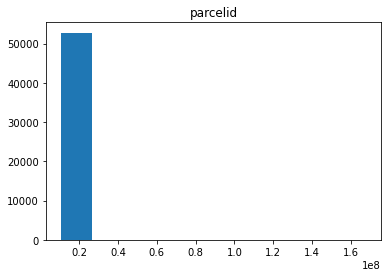

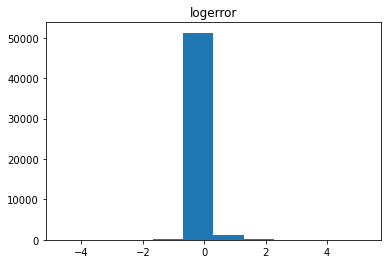

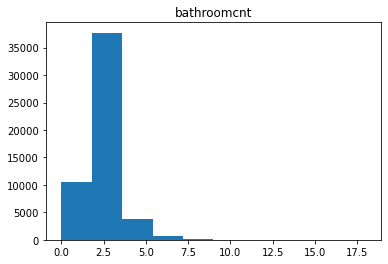

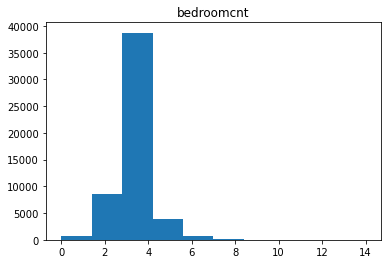

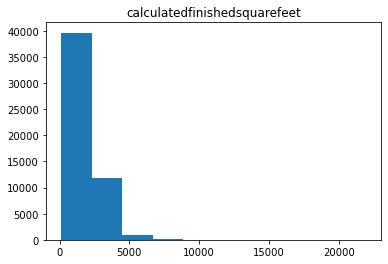

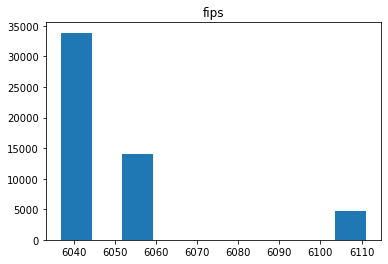

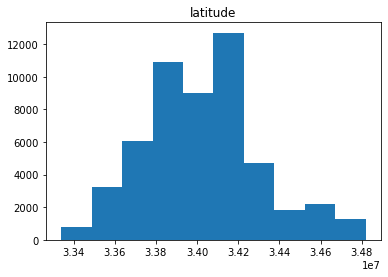

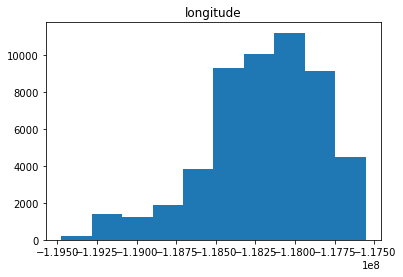

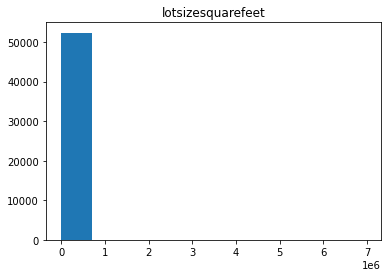

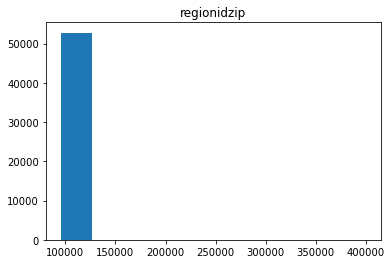

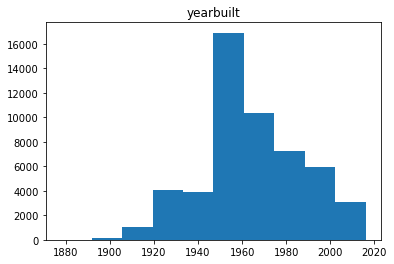

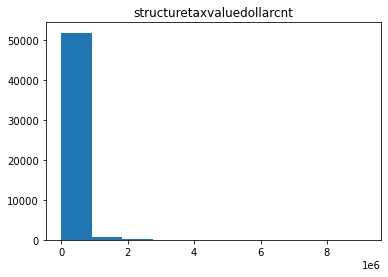

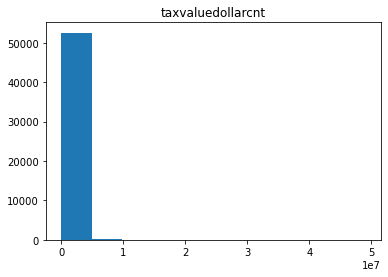

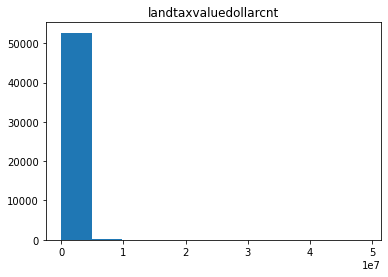

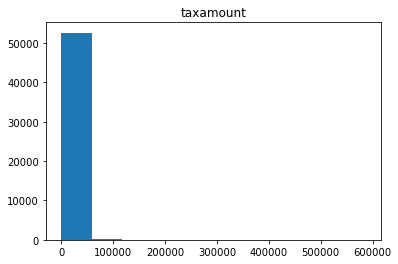

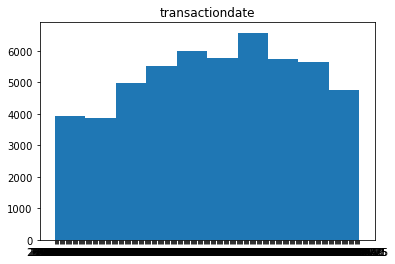

In [7]:
# visualize distributions

for col in df.columns:
    plt.hist(df[col])
    plt.title(col)
    plt.show()

### Looking at outliers:

In [8]:
# function that identifies outliers from wrangle.py

wrangle.outlier_bound_calculation(df, 'bedroomcnt')

For bedroomcnt the lower bound is 1.5 and  upper bound is 5.5


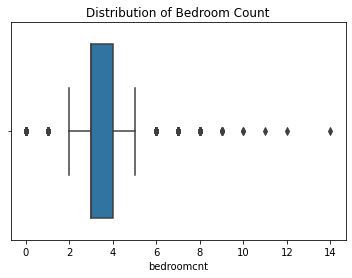

In [9]:
# visualize outliers in bedrooms
# I need to impute or drop these outliers

sns.boxplot(df.bedroomcnt)
plt.title('Distribution of Bedroom Count')
plt.show()

In [10]:
# function that identifies outliers from wrangle.py

wrangle.outlier_bound_calculation(df, 'bathroomcnt')

For bathroomcnt the lower bound is 0.5 and  upper bound is 4.5


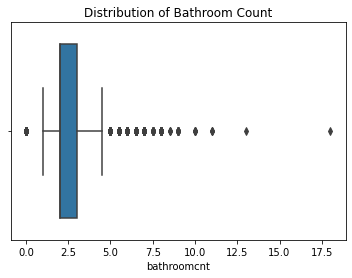

In [11]:
# visualize outliers in bathrooms

sns.boxplot(df.bathroomcnt)
plt.title('Distribution of Bathroom Count')
plt.show()

In [12]:
# function that identifies outliers from wrangle.py
# nan's will be fixed when I run final_prep_zillow function 

wrangle.outlier_bound_calculation(df, 'calculatedfinishedsquarefeet')

For calculatedfinishedsquarefeet the lower bound is nan and  upper bound is nan


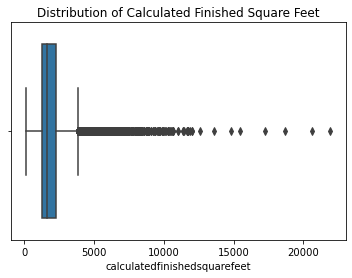

In [13]:
# visualize the same data as above

sns.boxplot(df.calculatedfinishedsquarefeet)
plt.title('Distribution of Calculated Finished Square Feet')
plt.show()

## Outliers Takeaway:
- I will use 'remove_outliers' function from wrangle.py to remove outliers that were outside upper_bound (.75) and lower_bound (.25) of IQR

### Looking at Nulls:

In [14]:
# null values

df.isnull().sum()

parcelid                          0
logerror                          0
bathroomcnt                       0
bedroomcnt                        0
calculatedfinishedsquarefeet    101
fips                              0
latitude                          0
longitude                         0
lotsizesquarefeet               399
regionidzip                      27
yearbuilt                       133
structuretaxvaluedollarcnt       93
taxvaluedollarcnt                 1
landtaxvaluedollarcnt             2
taxamount                         4
transactiondate                   0
dtype: int64

In [15]:
# nulls by column

explore.nulls_by_col(df)

,num_rows_missing,pct_rows_missing
parcelid,0,0.000000
logerror,0,0.000000
bathroomcnt,0,0.000000
bedroomcnt,0,0.000000
calculatedfinishedsquarefeet,101,0.191320
fips,0,0.000000
latitude,0,0.000000
longitude,0,0.000000
lotsizesquarefeet,399,0.755811
regionidzip,27,0.051145


In [16]:
# looking at nulls by row

explore.nulls_by_row(df)

,num_cols_missing,pct_cols_missing,num_rows
0,0,0.0,52189
1,1,6.25,476
2,2,12.5,99
3,3,18.75,24
4,4,25.0,1
5,5,31.25,2


### Nulls Takeaway:

- I will drop null values that fall outside the threshold using 'handling_missing_values' function (.5,.5) from wrangle.py
- I will impute the rest of the missing values that were not dropped

In [17]:
# function from wrangle.py that changes column names, changes dtypes, 
# imputes values, drop nulls and outliers, creates new column with county name

df = wrangle.final_prep_zillow(df)

In [18]:
# column names have been changed

df.head()

,parcelid,logerror,bathrooms,bedrooms,total_sqft,county_code,latitude,longitude,lotsizesquarefeet,regionidzip,year_built,structuretaxvaluedollarcnt,value_assessed,landtaxvaluedollarcnt,tax_amount,transactiondate,county,property_age
0,14297519,0.025595,3.5,4,3100,6059,33634931,-117869207,4506,96978,1998,485713,1023282,537569,11013,20170101,orange,19
1,17052889,0.055619,1.0,2,1465,6111,34449266,-119281531,12647,97099,1967,88000,464000,376000,5672,20170101,ventura,50
2,14186244,0.005383,2.0,3,1243,6059,33886168,-117823170,8432,97078,1962,85289,564778,479489,6488,20170101,orange,55
3,12177905,-0.103410,3.0,4,2376,6037,34245180,-118240722,13038,96330,1970,108918,145143,36225,1777,20170101,los_angeles,47
4,12095076,-0.001011,3.0,4,2962,6037,34145202,-118179824,63000,96293,1950,276684,773303,496619,9516,20170101,los_angeles,67


In [19]:
# changed dtypes

df.dtypes

parcelid                        int64
logerror                      float64
bathrooms                     float64
bedrooms                        int64
total_sqft                      int64
county_code                     int64
latitude                        int64
longitude                       int64
lotsizesquarefeet               int64
regionidzip                     int64
year_built                      int64
structuretaxvaluedollarcnt      int64
value_assessed                  int64
landtaxvaluedollarcnt           int64
tax_amount                      int64
transactiondate                 int64
county                         object
property_age                    int64
dtype: object

In [20]:
# dropped nulls outside of threshold 
# and imputed the rest of the null values 

df.isnull().sum()

parcelid                      0
logerror                      0
bathrooms                     0
bedrooms                      0
total_sqft                    0
county_code                   0
latitude                      0
longitude                     0
lotsizesquarefeet             0
regionidzip                   0
year_built                    0
structuretaxvaluedollarcnt    0
value_assessed                0
landtaxvaluedollarcnt         0
tax_amount                    0
transactiondate               0
county                        0
property_age                  0
dtype: int64

In [21]:
# new shape after dropping outliers and nulls that were not imputed

df.shape

(48646, 18)

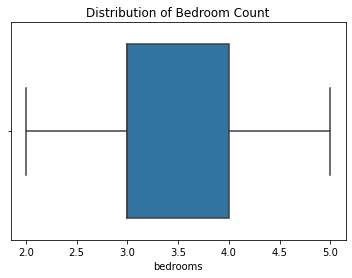

In [22]:
# visualize bedroom count after outliers were dropped

sns.boxplot(df.bedrooms)
plt.title('Distribution of Bedroom Count')
plt.show()

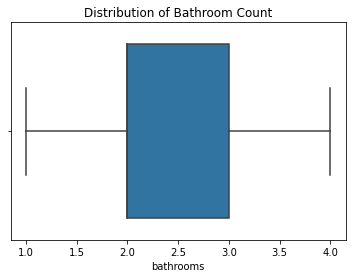

In [23]:
# visualize bathroom count after outliers were dropped

sns.boxplot(df.bathrooms)
plt.title('Distribution of Bathroom Count')
plt.show()

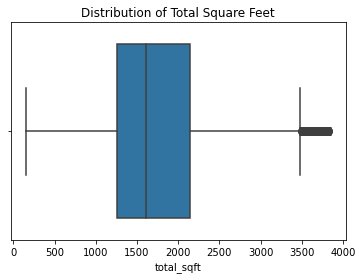

In [24]:
# visualize Total Square Feet "calculatedfinishedsquarefeet" after outliers were dropped

sns.boxplot(df.total_sqft)
plt.title('Distribution of Total Square Feet')
plt.show()

In [25]:
# target description

df.logerror.describe()

count    48646.000000
mean         0.016453
std          0.168115
min         -4.655420
25%         -0.025060
50%          0.006019
75%          0.038153
max          3.394544
Name: logerror, dtype: float64

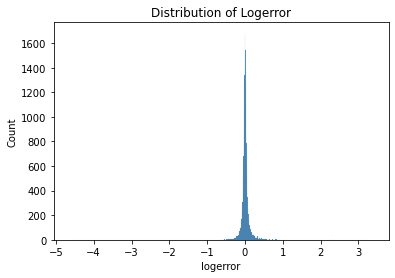

In [26]:
# distribution of log error (target)
# shows data above (mean right around 0)

sns.histplot(data=df.logerror)
plt.title('Distribution of Logerror')
plt.show()

In [27]:
df = df.drop(columns=('county'))

In [28]:
df.head()

,parcelid,logerror,bathrooms,bedrooms,total_sqft,county_code,latitude,longitude,lotsizesquarefeet,regionidzip,year_built,structuretaxvaluedollarcnt,value_assessed,landtaxvaluedollarcnt,tax_amount,transactiondate,property_age
0,14297519,0.025595,3.5,4,3100,6059,33634931,-117869207,4506,96978,1998,485713,1023282,537569,11013,20170101,19
1,17052889,0.055619,1.0,2,1465,6111,34449266,-119281531,12647,97099,1967,88000,464000,376000,5672,20170101,50
2,14186244,0.005383,2.0,3,1243,6059,33886168,-117823170,8432,97078,1962,85289,564778,479489,6488,20170101,55
3,12177905,-0.103410,3.0,4,2376,6037,34245180,-118240722,13038,96330,1970,108918,145143,36225,1777,20170101,47
4,12095076,-0.001011,3.0,4,2962,6037,34145202,-118179824,63000,96293,1950,276684,773303,496619,9516,20170101,67


### Split data

In [29]:
# use split function in wrangle.py

train, validate, test = wrangle.simple_split(df)

train -> (27241, 17)
validate -> (11675, 17)
test -> (9730, 17)


In [30]:
# train validate test split
# split data using zillow_split function from wrangle.py
# specify the target

X_train, X_validate, X_test, y_train, y_validate, y_test = wrangle.zillow_split(df, 'logerror')

In [31]:
# looking at X_train

X_train.head()

,parcelid,bathrooms,bedrooms,total_sqft,county_code,latitude,longitude,lotsizesquarefeet,regionidzip,year_built,structuretaxvaluedollarcnt,value_assessed,landtaxvaluedollarcnt,tax_amount,transactiondate,property_age
3951,10959540,1.0,2,1111,6037,34163106,-118345284,6485,96437,1940,72269,114085,41816,1274,20170127,77
28577,12435460,2.0,3,1218,6037,33829138,-118102359,4922,96242,1953,99570,465732,366162,5566,20170601,64
29574,10735170,2.0,4,2478,6037,34173439,-118653093,11390,96389,1963,148016,740087,592071,9130,20170606,54
47194,11205857,2.0,3,1312,6037,34562884,-118066075,4516,97328,1984,124008,155008,31000,2620,20170823,33
29812,11304609,3.0,5,3054,6037,34687100,-118202526,12969,97319,1998,253600,338000,84400,4812,20170606,19


### Scale data

In [32]:
# identify columns to be scaled

numeric_cols = ['bathrooms', 'bedrooms', 'total_sqft', 'county_code',
       'latitude', 'longitude', 'lotsizesquarefeet', 'regionidzip',
       'year_built', 'structuretaxvaluedollarcnt', 'value_assessed',
       'landtaxvaluedollarcnt', 'tax_amount',
       'property_age']

In [33]:
# use min_max_scaler function from wrangle.py

X_train_scaled, X_validate_scaled, X_test_scaled = wrangle.min_max_scaler(X_train, X_validate, X_test, numeric_cols)

In [34]:
# looking at data

X_train_scaled

,parcelid,bathrooms,bedrooms,total_sqft,county_code,latitude,longitude,lotsizesquarefeet,regionidzip,year_built,structuretaxvaluedollarcnt,value_assessed,landtaxvaluedollarcnt,tax_amount,transactiondate,property_age
3951,10959540,0.000000,0.000000,0.259892,0.000000,0.556430,0.588371,0.000861,0.001498,0.449275,0.027940,0.010659,0.004007,0.010140,20170127,0.550725
28577,12435460,0.333333,0.333333,0.288889,0.000000,0.330494,0.714843,0.000637,0.000856,0.543478,0.038540,0.043804,0.035853,0.045669,20170601,0.456522
29574,10735170,0.333333,0.666667,0.630352,0.000000,0.563421,0.428119,0.001565,0.001340,0.615942,0.057348,0.069663,0.058034,0.075172,20170606,0.384058
47194,11205857,0.333333,0.333333,0.314363,0.000000,0.826889,0.733734,0.000579,0.004432,0.768116,0.048028,0.014516,0.002946,0.021283,20170823,0.231884
29812,11304609,0.666667,1.000000,0.786450,0.000000,0.910924,0.662694,0.001792,0.004402,0.869565,0.098340,0.031764,0.008189,0.039428,20170606,0.130435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51744,10990894,0.333333,0.333333,0.418428,0.000000,0.619927,0.600166,0.001024,0.000988,0.724638,0.072555,0.031664,0.014605,0.034875,20170913,0.275362
51935,10712847,0.333333,1.000000,0.747696,0.000000,0.594889,0.437471,0.001681,0.001176,0.615942,0.123294,0.070719,0.042456,0.076670,20170913,0.384058
25911,14372063,0.500000,0.000000,0.342005,0.297297,0.202200,0.922936,0.000032,0.003227,0.731884,0.037692,0.030651,0.022367,0.028095,20170522,0.268116
34187,11700844,0.666667,0.333333,0.572900,0.000000,0.444162,0.592491,0.000953,0.000138,0.405797,0.066272,0.080589,0.067158,0.087647,20170623,0.594203


## Prepare Takeaway
- several columns were renamed in order to make them more legible
- duplicates were dropped on parcelid
- null values:
    - dropped if they fell outside of the threshold (0.5 column, 0.5 rows)
    - if fell inside the threshold, null values were imputed by 'mean' and 'most frequent'
- outliers were dropped from bedrooms, bathrooms, total_sqft columns
- final dataframe contains 48646 entries with 18 columns

## Explore

In [35]:
# summary function from explore.py

explore.summarize(df)

Dataframe head: 
   parcelid  logerror  bathrooms  bedrooms  total_sqft  county_code  latitude  \
0  14297519  0.025595        3.5         4        3100         6059  33634931   
1  17052889  0.055619        1.0         2        1465         6111  34449266   
2  14186244  0.005383        2.0         3        1243         6059  33886168   

   longitude  lotsizesquarefeet  regionidzip  year_built  \
0 -117869207               4506        96978        1998   
1 -119281531              12647        97099        1967   
2 -117823170               8432        97078        1962   

   structuretaxvaluedollarcnt  value_assessed  landtaxvaluedollarcnt  \
0                      485713         1023282                 537569   
1                       88000          464000                 376000   
2                       85289          564778                 479489   

   tax_amount  transactiondate  property_age  
0       11013         20170101            19  
1        5672         20170101    

(20170090.575000003, 20171143.4]    48645
(20171143.4, 20172185.8]                0
(20172185.8, 20173228.2]                0
(20173228.2, 20174270.6]                0
(20174270.6, 20175313.0]                0
(20175313.0, 20176355.4]                0
(20176355.4, 20177397.8]                0
(20177397.8, 20178440.2]                0
(20178440.2, 20179482.6]                0
(20179482.6, 20180525.0]                1
Name: transactiondate, dtype: int64
(0.861, 14.8]      2194
(14.8, 28.6]       4850
(28.6, 42.4]       6815
(42.4, 56.2]       9942
(56.2, 70.0]      16445
(70.0, 83.8]       3655
(83.8, 97.6]       3641
(97.6, 111.4]       931
(111.4, 125.2]      152
(125.2, 139.0]       21
Name: property_age, dtype: int64


#### What correlates to logerror

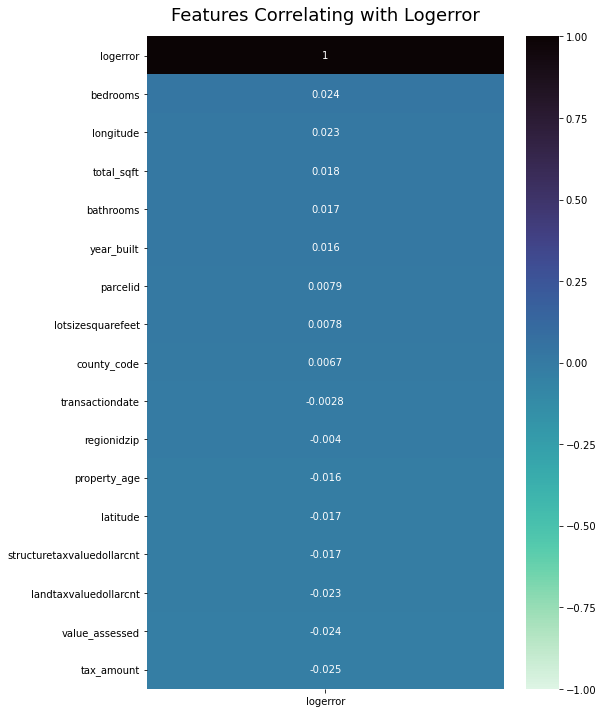

In [36]:
# see what correlates most with logerror with heatmap

plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['logerror']].sort_values(by='logerror', ascending=False), vmin=-1, vmax=1, annot=True, cmap='mako_r')
heatmap.set_title('Features Correlating with Logerror', fontdict={'fontsize':18}, pad=16);

### Feature Engineering

In [37]:
# Recursive Feature Elimination (RFE) to find best features for analysis

X = X_train[list(X_train.select_dtypes(exclude=['object']).columns)]
y = y_train

# create model

lm = LinearRegression()

# select hyperparameters

rfe = RFE(estimator=lm, n_features_to_select=3)

# fit model

rfe.fit(X, y)

X.columns[rfe.support_]

Index(['year_built', 'value_assessed', 'property_age'], dtype='object')

In [38]:
# check ranking 

pd.Series(dict(zip(X.columns, rfe.ranking_))).sort_values()

year_built                     1
value_assessed                 1
property_age                   1
landtaxvaluedollarcnt          2
structuretaxvaluedollarcnt     3
tax_amount                     4
total_sqft                     5
regionidzip                    6
lotsizesquarefeet              7
longitude                      8
bedrooms                       9
county_code                   10
bathrooms                     11
latitude                      12
transactiondate               13
parcelid                      14
dtype: int64

### Heatmap and RFE Takeaway:
- year built, value, age, bedrooms, longitude and total sqft seem to be most important

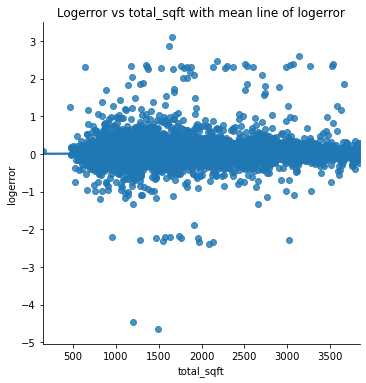

In [39]:
# visualize Log error vs total_sqft

sns.lmplot(x='total_sqft', y='logerror', data=train)
plt.title('Logerror vs total_sqft with mean line of logerror')
plt.show()

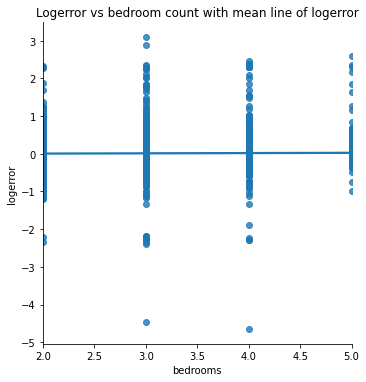

In [40]:
# visualize log error vs bedroom count

sns.lmplot(x='bedrooms', y='logerror', data=train)
plt.title('Logerror vs bedroom count with mean line of logerror')
plt.show()

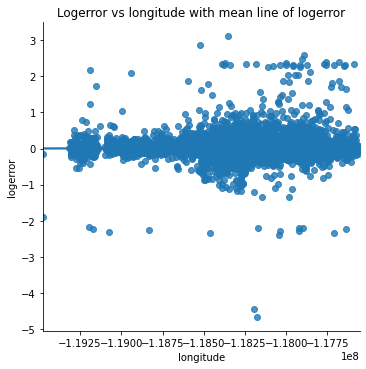

In [41]:
# visualize log error vs longitude

sns.lmplot(x='longitude', y='logerror', data=train)
plt.title('Logerror vs longitude with mean line of logerror')
plt.show()

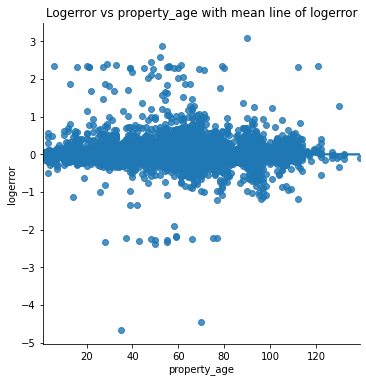

In [42]:
# visualize log error vs property age

sns.lmplot(x='property_age', y='logerror', data=train)
plt.title('Logerror vs property_age with mean line of logerror')
plt.show()

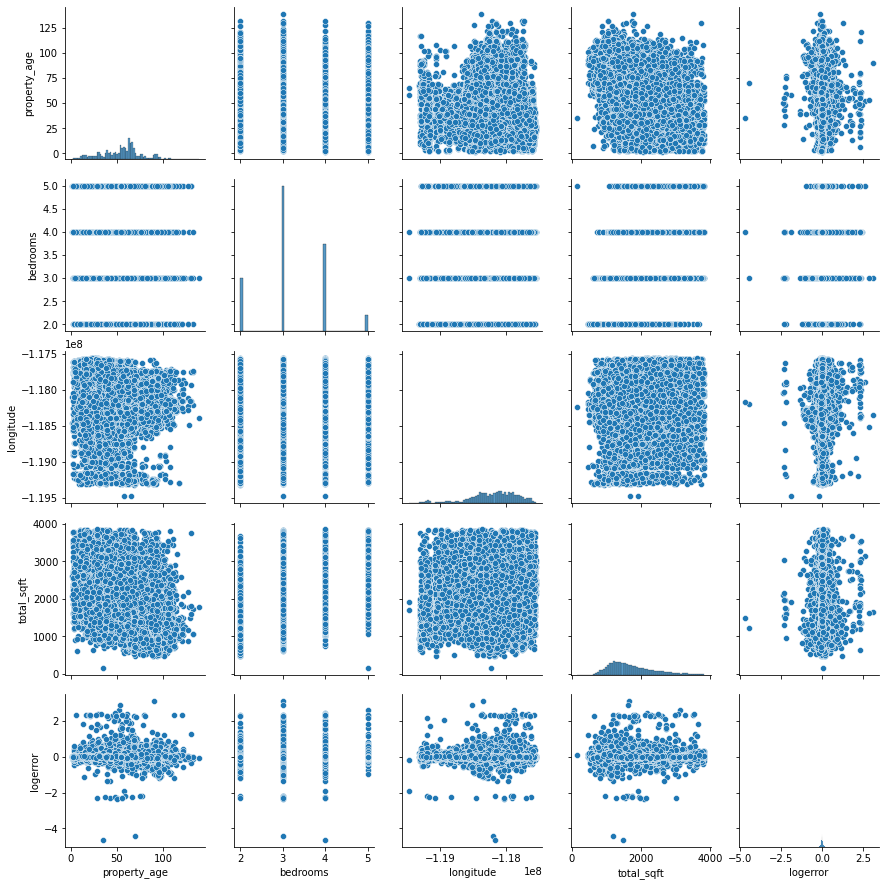

In [43]:
# create pairplot in train dataset

cols = ['property_age', 'bedrooms', 'longitude', 'total_sqft', 'logerror']

sns.pairplot(data = train[cols])
plt.show()

### Takeaways:
- cannot visualize any significant clusters at this point

## Hypothesis Testing:

- correlation testing: tests 2 continuous variables
- pearsons looks to find if two sample have a linear relationship
- r, p = stats.pearsonsr(x,y)

<br>

- T-Test: tests a continuous and a discrete variable
- t, p = stats.ttest_ind(x,y, equal_var= )


### Hypothesis 1: Correlation Test (Sqft vs Logerror)
- $H_0$: There is no correlation between log error and total square feet of the property
- $H_a$: There is a correlation between log error and total square feet of the property

In [44]:
# set alpha

alpha = .05

r, p = stats.pearsonr(train.logerror, train.total_sqft)
print('r-value:',round(r,4),'p-value:',round(p,4))

r-value: 0.0261 p-value: 0.0


In [45]:
if p < alpha: 
    print('We reject the null hypothesis. There is a relationship between log error and total square feet')
else:
    print('We fail to reject the null hypothesis. There is no relationship between log error and total square feet')

We reject the null hypothesis. There is a relationship between log error and total square feet


### Hypothesis 2: Correlation Test (Logerror vs Property_Age)
- $H_0$: There is no correlation between log error and age of the property
- $H_a$: There is a correlation between log error and age of the property

In [46]:
# set alpha

alpha = .05

r, p = stats.pearsonr(train.logerror, train.property_age)
print('r-value:',round(r,4),'p-value:',round(p,4))

r-value: -0.0221 p-value: 0.0003


In [47]:
if p < alpha: 
    print('We reject the null hypothesis. There is a relationship between log error and age of the property')
else:
    print('We fail to reject the null hypothesis. There is no relationship between log error and age of the property')

We reject the null hypothesis. There is a relationship between log error and age of the property


### Hypothesis 3: Correlation Test (Longitude vs Logerror)
- $H_0$: There is no correlation between log error and longitude
- $H_a$: There is a correlation between log error and longitude

In [48]:
# set alpha

alpha = .05
#r,p = stats.pearsonsr(x,y)
r, p = stats.pearsonr(train.logerror, train.longitude)

print('r-value:',round(r,4),'p-value:',round(p,4))

r-value: 0.0226 p-value: 0.0002


In [49]:
if p < alpha: 
    print('We reject the null hypothesis. There is a relationshiop between log error and longitude')
else:
    print('We fail to reject the null hypothesis. There is no relationshiop between log error and longitude')

We reject the null hypothesis. There is a relationshiop between log error and longitude


### Hypothesis 4: T-Test (Bedrooms vs Logerror)
- $H_0$: There is no relationship between log error and bedroom count
- $H_a$: There is a relationship between log error and bedroom count

In [50]:
# set alpha

alpha = .05

In [51]:
# sample size, must be more then 30 to meet assumption

train.logerror.count(), train.bedrooms.count()

(27241, 27241)

In [52]:
# check variance

train.value_assessed.var(), train.bedrooms.var()

# this shows not equal varient

(174486052492.40094, 0.6332561061943373)

In [53]:
#t-test on entire train set

t, p = stats.ttest_ind(train.bedrooms,train.logerror, equal_var=False)

print('t-value:',round(t,4),'p-value:',round(p,4))

t-value: 651.1928 p-value: 0.0


In [54]:
if p < alpha: 
    print('We reject the null hypothesis. There is a relationship between log error and number of bedrooms')
else:
    print('We fail to reject the null hypothesis. There is no relationship between log error and number of bedrooms')

We reject the null hypothesis. There is a relationship between log error and number of bedrooms


### Hypothesis Testing Takeaway:
- We reject the null hypothesis on all four hypothesis test.
- There are relationships between the features and log error

## Clustering

Questions:

- What is a logerror
    - predicted sale value being different from actual sale value
 
 
- Possible reasons for logerror
    - age of property
    - location of property
    - number of rooms
    - square feet of the property

### Cluster #1

In [55]:
# chose variables for this possible cluster

X = train[['longitude', 'total_sqft']]

# take a look

X.head()

,longitude,total_sqft
3951,-118345284,1111
28577,-118102359,1218
29574,-118653093,2478
47194,-118066075,1312
29812,-118202526,3054


In [56]:
# Scale the X

scaler = StandardScaler().fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])

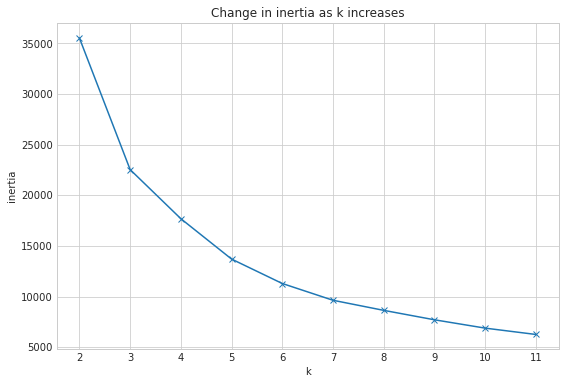

In [57]:
# lets plot inertia vs k

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

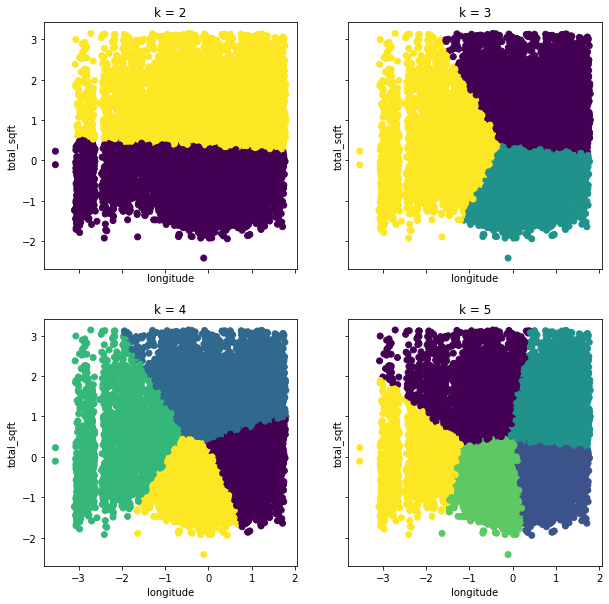

In [58]:
# use scatter_plot function from explore.py
# this will show you different clusters with varying k values

explore.scatter_plots(X_scaled, col_name= 'longitude', col_name_two= 'total_sqft')

In [59]:
# use create_cluster function from explore.py

train, X_scaled, scaler, kmeans, centroids_scaled = explore.create_cluster(train, X, 5, col_name= 'cluster_longitude_totalsqft')

In [60]:
# looking at the new column

train.head()

,parcelid,logerror,bathrooms,bedrooms,total_sqft,county_code,latitude,longitude,lotsizesquarefeet,regionidzip,year_built,structuretaxvaluedollarcnt,value_assessed,landtaxvaluedollarcnt,tax_amount,transactiondate,property_age,cluster_longitude_totalsqft
3951,10959540,0.020346,1.0,2,1111,6037,34163106,-118345284,6485,96437,1940,72269,114085,41816,1274,20170127,77,2
28577,12435460,0.000221,2.0,3,1218,6037,33829138,-118102359,4922,96242,1953,99570,465732,366162,5566,20170601,64,1
29574,10735170,-0.019788,2.0,4,2478,6037,34173439,-118653093,11390,96389,1963,148016,740087,592071,9130,20170606,54,0
47194,11205857,-0.011734,2.0,3,1312,6037,34562884,-118066075,4516,97328,1984,124008,155008,31000,2620,20170823,33,1
29812,11304609,0.005586,3.0,5,3054,6037,34687100,-118202526,12969,97319,1998,253600,338000,84400,4812,20170606,19,0


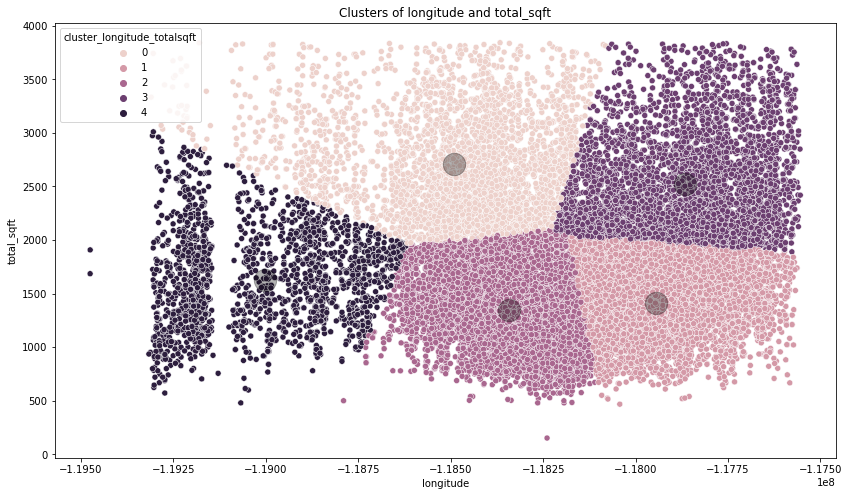

In [61]:
# plot only k=5

plt.figure(figsize=(14, 8))
sns.scatterplot(x = 'longitude', y = 'total_sqft', data = train, hue = 'cluster_longitude_totalsqft')
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)
centroids.plot.scatter(y='total_sqft', x= 'longitude', ax=plt.gca(), alpha=.30, s=500, c='black')
plt.title('Clusters of longitude and total_sqft')
plt.show()

### Cluster #1 Takeaway:

- inertia seems to be flattening out around k=5 

- **cluster_0**: longitude between -1.194 to -1.18 and sqft of ~2000 to ~3800 

- **cluster_1**: longitude between -1.18 to -1.175 and sqft of ~500 to ~2000 

- **cluster_2**: longitude between -1.1875 to -1.1826 and sqft of ~100 to ~2000 

- **cluster_3**: longitude between -1.1825 to -1.1750 and sqft of ~2000 to ~3800  

- **cluster_4**: longitude between -1.1950 to -1.186 and sqft of ~500 to ~3000 

## Cluster #2

In [62]:
# chose variables for this possible cluster

X2 = train[['property_age', 'total_sqft']]

# take a look

X2.head()

,property_age,total_sqft
3951,77,1111
28577,64,1218
29574,54,2478
47194,33,1312
29812,19,3054


In [63]:
# Scale the X

scaler = StandardScaler().fit(X2)
X2_scaled = pd.DataFrame(scaler.transform(X2), columns= X2.columns).set_index([X2.index.values])

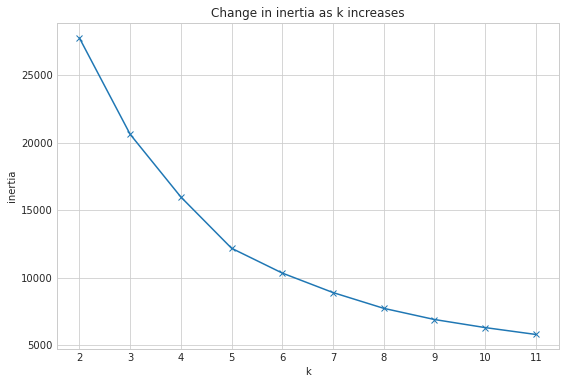

In [64]:
# lets plot inertia vs k

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X2_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

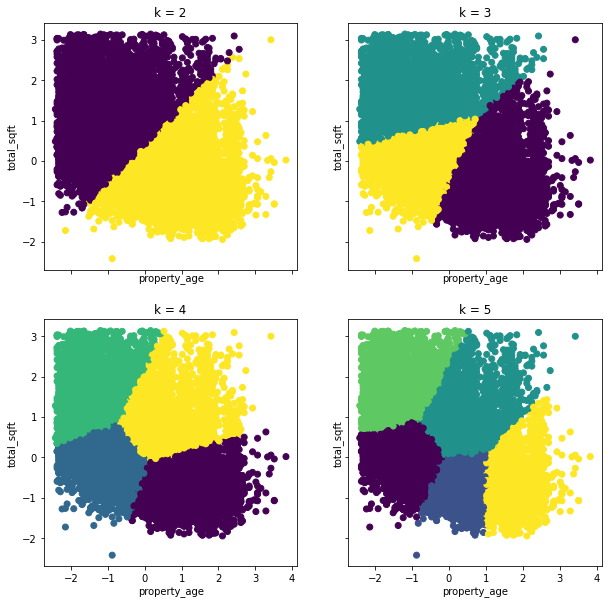

In [65]:
# use scatter_plots function from explore.py
# this will show you different clusters with varying k values

explore.scatter_plots(X2_scaled, col_name= 'property_age', col_name_two= 'total_sqft')

In [66]:
# use create_cluster function from explore.py

train, X2_scaled, scaler, kmeans, centroids_scaled = explore.create_cluster(train, X2, 3, col_name= 'cluster_age_totalsqft')

In [67]:
# take a look at the new column

train.head()

,parcelid,logerror,bathrooms,bedrooms,total_sqft,county_code,latitude,longitude,lotsizesquarefeet,regionidzip,year_built,structuretaxvaluedollarcnt,value_assessed,landtaxvaluedollarcnt,tax_amount,transactiondate,property_age,cluster_longitude_totalsqft,cluster_age_totalsqft
3951,10959540,0.020346,1.0,2,1111,6037,34163106,-118345284,6485,96437,1940,72269,114085,41816,1274,20170127,77,2,1
28577,12435460,0.000221,2.0,3,1218,6037,33829138,-118102359,4922,96242,1953,99570,465732,366162,5566,20170601,64,1,1
29574,10735170,-0.019788,2.0,4,2478,6037,34173439,-118653093,11390,96389,1963,148016,740087,592071,9130,20170606,54,0,2
47194,11205857,-0.011734,2.0,3,1312,6037,34562884,-118066075,4516,97328,1984,124008,155008,31000,2620,20170823,33,1,0
29812,11304609,0.005586,3.0,5,3054,6037,34687100,-118202526,12969,97319,1998,253600,338000,84400,4812,20170606,19,0,2


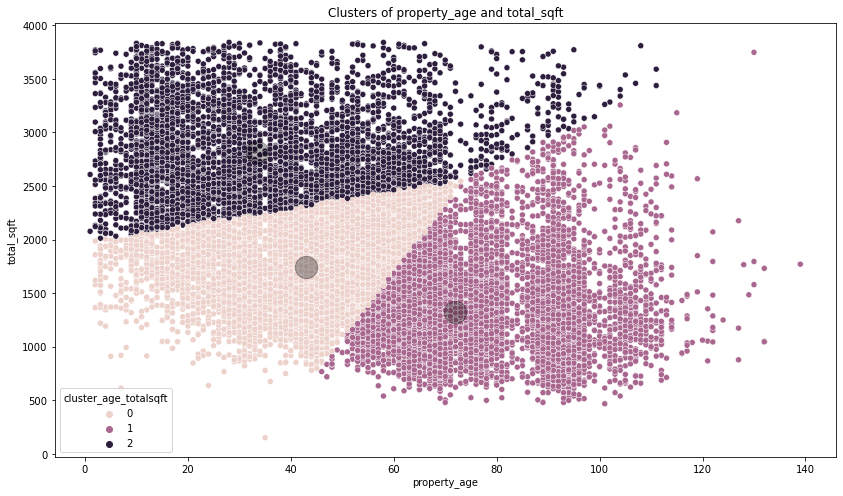

In [68]:
# plot only k=3

plt.figure(figsize=(14, 8))
sns.scatterplot(x = 'property_age', y = 'total_sqft', data = train, hue = 'cluster_age_totalsqft')
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X2_scaled.columns)
centroids.plot.scatter(y='total_sqft', x= 'property_age', ax=plt.gca(), alpha=.30, s=500, c='black')
plt.title('Clusters of property_age and total_sqft')
plt.show()

### Cluster #2 Takeaway:

- **cluster_0**: Younger Homes 
    - the property age range (between 0 to ~75 years old)
    - Sqft of property upto 2500 sqft. 


- **cluster_1**: Older Homes
    - age of property between ~45 to ~115 years old (with some outliers)
    - had oldest homes
    - more smaller homes
    - Sqft uptoto ~3000 (with some outliers)  


- **cluster_2**: Larger Homes
    - age of property between 0 year to 75 years(with some outliers) 
    - Sqft of ~2000 and up 


## Cluster #3

In [69]:
# chose variables for this possible cluster

X3 = train[['bedrooms', 'property_age']]

# take a look

X3.head()

,bedrooms,property_age
3951,2,77
28577,3,64
29574,4,54
47194,3,33
29812,5,19


In [70]:
# Scale the X

scaler = StandardScaler().fit(X3)
X3_scaled = pd.DataFrame(scaler.transform(X3), columns= X3.columns).set_index([X3.index.values])

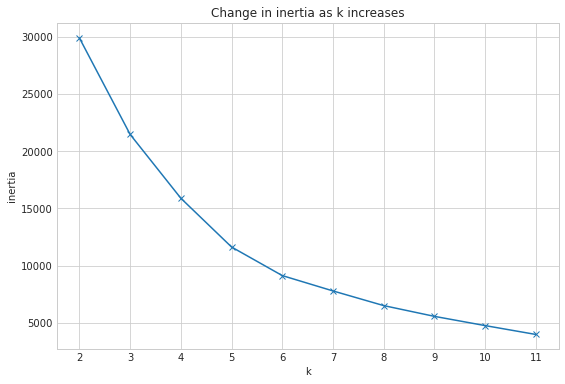

In [71]:
# lets plot inertia vs k

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X3_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

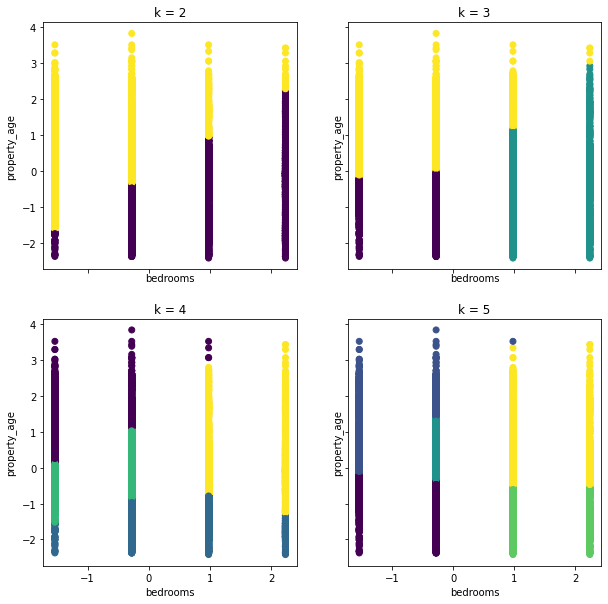

In [72]:
# use scatter_plots function from explore.py
# this will show you different clusters with varying k values

explore.scatter_plots(X3_scaled, col_name= 'bedrooms', col_name_two= 'property_age')

In [73]:
# use create_cluster function from explore.py

train, X3_scaled, scaler, kmeans, centroids_scaled = explore.create_cluster(train, X3, 4, col_name= 'cluster_age_bedrooms')

In [74]:
# take a look at the new column

train.head()

,parcelid,logerror,bathrooms,bedrooms,total_sqft,county_code,latitude,longitude,lotsizesquarefeet,regionidzip,year_built,structuretaxvaluedollarcnt,value_assessed,landtaxvaluedollarcnt,tax_amount,transactiondate,property_age,cluster_longitude_totalsqft,cluster_age_totalsqft,cluster_age_bedrooms
3951,10959540,0.020346,1.0,2,1111,6037,34163106,-118345284,6485,96437,1940,72269,114085,41816,1274,20170127,77,2,1,3
28577,12435460,0.000221,2.0,3,1218,6037,33829138,-118102359,4922,96242,1953,99570,465732,366162,5566,20170601,64,1,1,0
29574,10735170,-0.019788,2.0,4,2478,6037,34173439,-118653093,11390,96389,1963,148016,740087,592071,9130,20170606,54,0,2,1
47194,11205857,-0.011734,2.0,3,1312,6037,34562884,-118066075,4516,97328,1984,124008,155008,31000,2620,20170823,33,1,0,2
29812,11304609,0.005586,3.0,5,3054,6037,34687100,-118202526,12969,97319,1998,253600,338000,84400,4812,20170606,19,0,2,2


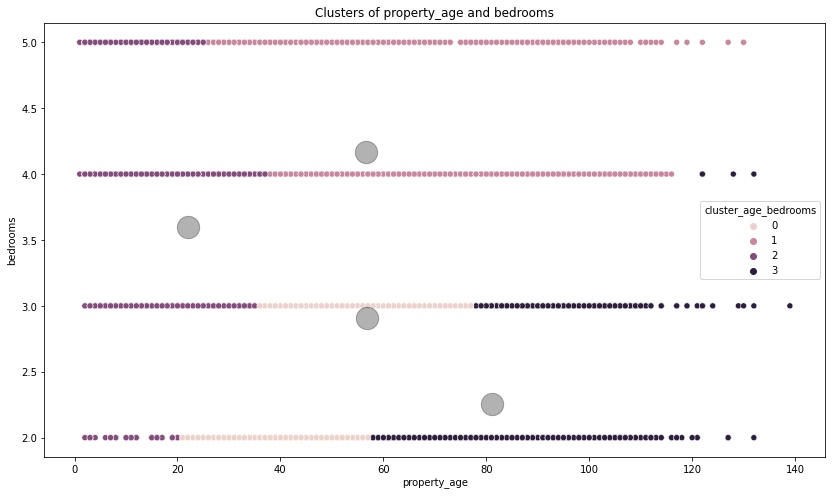

In [75]:
# plot only k=4

plt.figure(figsize=(14, 8))
sns.scatterplot(x = 'property_age', y = 'bedrooms', data = train, hue = 'cluster_age_bedrooms')
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X3_scaled.columns)
centroids.plot.scatter(y='bedrooms', x= 'property_age', ax=plt.gca(), alpha=.30, s=500, c='black')
plt.title('Clusters of property_age and bedrooms')
plt.show()

### Cluster #3 Takeaway:

- **cluster_0**: Average Home
    - 2 or 3 bedrooms
    - 20 years old to 80 years old 


- **cluster_1**: Large Homes
    -  4 or 5 bedrooms
    - 25 years old to ~135 years old


- **cluster_2**: Younger Homes
    - have largest range of bedrooms (2-5)
    - 0 years old to ~38 years old
    

- **cluster_3**: Older Homes
    - 2 or 3 bedrooms (few with 4)
    - ~58 years old to ~135 years old

## Run Stats Tests on Clusters

### Cluster #1 Stats Test- Longitude and Total Sqft

- $H_0$: There is no relationship between log error and cluster #1
- $H_a$: There is a relationship between log error and cluster #1

In [76]:
# set alpha

alpha = .05

# r,p = stats.pearsonsr(x,y)

r, p = stats.pearsonr(train.logerror, train.cluster_longitude_totalsqft)

print('r-value:',round(r,4),'p-value:',round(p,4))

r-value: -0.0048 p-value: 0.4289


In [77]:
if p < alpha: 
    print('We reject the null hypothesis. There is a relationship between log error and cluster #1')
else:
    print('We fail to reject the null hypothesis There is no relationship between log error and cluster #1')

We fail to reject the null hypothesis There is no relationship between log error and cluster #1


#### Cluster #1 Stats Takeaway:
- This cluster does not appear to be viable in predicting logerror

### Cluster #2 Stats Test- Age of Property and Total Sqft

- $H_0$: There is no relationship between log error and cluster #2
- $H_a$: There is a relationship between log error and cluster #2

In [78]:
# set alpha

alpha = .05

# r,p = stats.pearsonsr(x,y)

r, p = stats.pearsonr(train.logerror, train.cluster_age_totalsqft)

print('r-value:',round(r,4),'p-value:',round(p,4))

r-value: 0.0139 p-value: 0.0218


In [79]:
if p < alpha: 
    print('We reject the null hypothesis. There is a relationship between log error and cluster #2')
else:
    print('We fail to reject the null hypothesis. There is no relationship between log error and cluster #2')

We reject the null hypothesis. There is a relationship between log error and cluster #2


#### Cluster #2 Stats Takeaway:
- Possible use of cluster for modeling

### Cluster #3 Stats Test- Age of Property and Bedroom Count

- $H_0$: There is no relationship between log error and cluster #3
- $H_a$: There is a relationship between log error and cluster #3

In [80]:
# set alpha

alpha = .05

# r,p = stats.pearsonsr(x,y)

r, p = stats.pearsonr(train.logerror, train.cluster_age_bedrooms)

print('r-value:',round(r,4),'p-value:',round(p,4))

r-value: -0.0114 p-value: 0.0593


In [81]:
if p < alpha: 
    print('We reject the null hypothesis. There is a relationship between log error and cluster #3')
else:
    print('We fail to reject the null hypothesis. There is no relationship between log error and cluster #3')

We fail to reject the null hypothesis. There is no relationship between log error and cluster #3


#### Cluster #3 Stats Takeaway:
- May be able to cluster to work, may look at different approach

# Model

In [82]:
# need y_train and y_validate to be dataframes to append the new columns with predicted values

y_train = pd.DataFrame({'actual': y_train})
y_validate = pd.DataFrame({'actual': y_validate})
y_test = pd.DataFrame({'actual': y_test})

## Create Baseline

In [83]:
# create baseline

baseline = y_train['actual'].mean()

In [84]:
# create column called baseline to compare

y_train['baseline'] = baseline

In [85]:
# calculate RMSE for baseline model

rmse_baseline_train = math.sqrt(mean_squared_error(y_train.actual, y_train.baseline))

In [86]:
# predict validate
y_validate['baseline'] = baseline

# evaluate: rmse
rmse_baseline_validate = math.sqrt(mean_squared_error(y_validate.actual, y_validate.baseline))

In [87]:
# create dataframe to make data easier to visualize/understand

metric_df = pd.DataFrame(data=[{
    'model': 'mean_baseline',
    'rmse_train': round(rmse_baseline_train, 5),
    'rmse_validate': round(rmse_baseline_validate, 5)
}])

metric_df

# baseline model to work with

,model,rmse_train,rmse_validate
0,mean_baseline,0.16587,0.17699


In [88]:
# set features
# do not want to include all columns in this because it could cause overfitting

features = ['property_age', 'total_sqft', 'bedrooms']

## Model #1: OLS 

In [89]:
# Ordinary Least Squares (OLS)
# create the model

model1 = LinearRegression(normalize=True)

# fit the model

model1.fit(X_train_scaled[features], y_train.actual)

LinearRegression(normalize=True)

In [90]:
# predict train

y_train['logerror_pred_lm'] = model1.predict(X_train_scaled[features])

# evaluate: rmse

rmse_train = mean_squared_error(y_train.actual, y_train.logerror_pred_lm)**(1/2)

# predict validate

y_validate['logerror_pred_lm'] = model1.predict(X_validate_scaled[features])

# evaluate: rmse

rmse_validate = mean_squared_error(y_validate.actual, y_validate.logerror_pred_lm)**(1/2)

In [91]:
# create visual to see baseline vs LinearRegression model

metric_df = metric_df.append(
    {
    'model': 'Model 1: OLS',
    'rmse_train': round(rmse_train, 5),
    'rmse_validate': round(rmse_validate,5),
    }, ignore_index=True)

metric_df

,model,rmse_train,rmse_validate
0,mean_baseline,0.16587,0.17699
1,Model 1: OLS,0.16577,0.17691


## Model #2: Lasso Lars

In [92]:
# create the model object

model2 = LassoLars(alpha = 2)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 

model2.fit(X_train_scaled[features], y_train.actual)

# predict train

y_train['logerror_pred_lars'] = model2.predict(X_train_scaled[features])

# evaluate: rmse

rmse_train = mean_squared_error(y_train.actual, y_train.logerror_pred_lars)**(1/2)

# predict validate

y_validate['logerror_pred_lars'] = model2.predict(X_validate_scaled[features])

# evaluate: rmse

rmse_validate = mean_squared_error(y_validate.actual, y_validate.logerror_pred_lars)**(1/2)

In [93]:
# show baseline vs LinearRegression vs LassoLars

metric_df = metric_df.append(
    {
    'model': 'Model 2: LassoLars (alpha 2)',
    'rmse_train': round(rmse_train,5),
    'rmse_validate': round(rmse_validate,5),
    }, ignore_index=True)

metric_df

,model,rmse_train,rmse_validate
0,mean_baseline,0.16587,0.17699
1,Model 1: OLS,0.16577,0.17691
2,Model 2: LassoLars (alpha 2),0.16587,0.17699


## Model #3: Polynomial Features

In [94]:
# make the polynomial features to get a new set of features

model3 = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled features

X_train_degree2 = model3.fit_transform(X_train_scaled[features])

# transform X_validate_scaled

X_validate_degree2 = model3.transform(X_validate_scaled[features])


In [95]:
# create the model

lm2 = LinearRegression(normalize=True)

# fit the mode

lm2.fit(X_train_degree2, y_train.actual)

# use the model

y_train['logerror_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse

rmse_train_model3 = mean_squared_error(y_train.actual, y_train.logerror_pred_lm2) ** (1/2)

# predict validate

y_validate['logerror_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse

rmse_validate_model3 = mean_squared_error(y_validate.actual, y_validate.logerror_pred_lm2) ** (1/2)

In [96]:
# show baseline vs LinearRegression vs LassoLars

metric_df = metric_df.append(
    {
    'model': 'Model 3: Polynomial Regression (degree=2)',
    'rmse_train': round(rmse_train_model3,5),
    'rmse_validate': round(rmse_validate_model3,5),
    }, ignore_index=True)

metric_df

,model,rmse_train,rmse_validate
0,mean_baseline,0.16587,0.17699
1,Model 1: OLS,0.16577,0.17691
2,Model 2: LassoLars (alpha 2),0.16587,0.17699
3,Model 3: Polynomial Regression (degree=2),0.16569,0.17681


## Model #4: OLS on Unscaled Data

In [97]:
# ordinary least squares
# create the model 
# try on unscaled data

model4 = LinearRegression(normalize=True)

# fit the model

model4.fit(X_train[features], y_train.actual)

LinearRegression(normalize=True)

In [98]:
# predict train

y_train['pred_lm_unscaled'] = model4.predict(X_train[features])

# evaluate: rmse

rmse_train = mean_squared_error(y_train.actual, y_train.logerror_pred_lm)**(1/2)

# predict validate

y_validate['pred_lm_unscaled'] = model4.predict(X_validate[features])

# evaluate: rmse

rmse_validate = mean_squared_error(y_validate.actual, y_validate.logerror_pred_lm)**(1/2)

In [99]:
# create visual to see baseline vs LinearRegression model
# try on unscaled data

metric_df = metric_df.append(
    {
    'model': 'Model 4: OLS (Unscaled Data)',
    'rmse_train': round(rmse_train, 5),
    'rmse_validate': round(rmse_validate,5),
    }, ignore_index=True)

metric_df

,model,rmse_train,rmse_validate
0,mean_baseline,0.16587,0.17699
1,Model 1: OLS,0.16577,0.17691
2,Model 2: LassoLars (alpha 2),0.16587,0.17699
3,Model 3: Polynomial Regression (degree=2),0.16569,0.17681
4,Model 4: OLS (Unscaled Data),0.16577,0.17691


### Use test set on best model - Model 3: Polynomial Regression (degree=2)

In [100]:
X_test_2 = X_test_scaled[['property_age','bedrooms','total_sqft']]

X_test_degree2 = model3.transform(X_test_2)

# predict validate

y_test['poly_2'] = lm2.predict(X_test_degree2)

# evaluate: rmse

rmse_validate = (mean_squared_error(y_test.actual, y_test.poly_2))**(1/2)

print(f'RMSE: {round(mean_squared_error(y_test.actual, y_test.poly_2)**(1/2), 5)}')

RMSE: 0.16355


In [101]:
# percent_improve =  (baseline - rmse_validate) / baseline

percent_improve =  (0.16587 - 0.16355) / 0.16587

print(f'Model Performs {percent_improve:.1%} better than the baseline')

Model Performs 1.4% better than the baseline


## Modeling Takeaway:

- Polynomial Regression models performed best on train and validate
- LassoLars performed the same as the basline
- OLS models performed the same on the scaled and unscaled data


# Final Takeaways:

- The 2nd degree polynomial regression model was able to better predict sale values thus reducing logerror

- Decided not to use my clusters as a feature to model with this time

- The real estate market and other unknown factors can cause the zestimate to be off and increasing the logerror. eg. home sellers personal situation or price negotiations between buyer and seller

#### With more time:

- I would like to find if there are better predictors of log error by creating more clusters

- I would like to improve models by trying different clusters/features and algorithms

- I would like to use a cluster as a feature in modeling next time
